# CampaignSense — Camada de Decisioning e Profit Targeting

## Objetivo deste notebook

Este notebook implementa a **camada de decisioning** da POC CampaignSense, responsável por converter o score de propensão do modelo campeão em **decisões operacionais explícitas**, orientadas a lucro.

Nesta etapa, o modelo preditivo atua exclusivamente como **insumo analítico** (`P(response)`), enquanto a decisão de ação (quem contatar) é definida de forma **determinística**, a partir de premissas explícitas de ganho e custo.

---

## Papel do decisioning na CampaignSense

No pipeline da CampaignSense, a camada de decisioning:

- estabelece a separação explícita entre **predição** e **decisão**;
- traduz `P(response)` em **lucro esperado** ao nível do cliente;
- define políticas de contato baseadas em **profit targeting**;
- explicita trade-offs entre **impacto financeiro** e **volume acionado**;
- gera o output final de negócio: **lista priorizada de clientes**, impacto estimado e **Campaign Summary**.

Este notebook representa a transição da CampaignSense de um modelo de propensão para um **motor de decisão orientado a valor**.

---

## Escopo e decisões importantes

- O modelo campeão é definido no Notebook 04.
- A política de decisão é **derivada no conjunto VALID** e aplicada no TEST em regime *one-shot*, sem recalibração.
- `GAIN` e `COST` são tratados como **premissas explícitas** de unit economics e podem ser ajustados como cenários.
- A segmentação é utilizada exclusivamente como **camada explicativa**, não como feature obrigatória do modelo.
- Nenhuma decisão é aprendida automaticamente:  
  todas as regras adotadas são **explícitas, determinísticas e auditáveis**.

## 1. Setup e carregamento dos dados

In [1]:
# Governança: habilita import de módulos do projeto a partir do diretório /notebooks
import sys
sys.path.insert(0, "..")

# Standard library
import json

# Third-party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Persistence
import joblib

# Local
from src.paths import (
    PROCESSED_SEGMENTS,
    PROCESSED_TEST,
    PROCESSED_VALID,
    REPORTS_FOLDER,
    METRICS_FOLDER,
    MODELS_FOLDER,
    TABLES_FOLDER,
    PLOTS_FOLDER,
)

In [2]:
# Governança: seed global para reprodutibilidade do notebook
SEED = 42
np.random.seed(SEED)

# Configuração de exibição (não altera a persistência dos dados)
sns.set_theme(style="whitegrid", context="notebook")

In [3]:
# Carregamento dos datasets
df_valid = pd.read_parquet(PROCESSED_VALID)
df_test  = pd.read_parquet(PROCESSED_TEST)

# Carregamentos  daddos de segmentação
df_segments = pd.read_parquet(PROCESSED_SEGMENTS)

In [4]:
# Verificação inicial de dimensões
print(f"Split train: {df_test.shape[0]} linhas x {df_test.shape[1]} colunas")
print(f"Split valid: {df_valid.shape[0]} linhas x {df_valid.shape[1]} colunas")
print(f"Segments: {df_segments.shape[0]} linhas x {df_segments.shape[1]} colunas")

Split train: 448 linhas x 33 colunas
Split valid: 358 linhas x 33 colunas
Segments: 2237 linhas x 3 colunas


In [5]:
# Carregamento do modelo 
model = joblib.load(MODELS_FOLDER / "xgb_model.joblib")

## 2. Funções auxiliares

### 2.1. Cálculo de lucro esperado

In [6]:
# Converte score de propensão em valor econômico esperado por cliente
def compute_expected_profit(
    p_response,
    gain: float,
    cost: float,
):
    """
    Calcula o lucro esperado por cliente a partir da probabilidade de resposta.

    O lucro esperado é definido como:
        Expected Profit = P(response) * gain - cost

    Parâmetros
    ----------
    p_response : float ou array-like
        Probabilidade estimada de resposta do cliente (output do modelo).
    gain : float
        Ganho unitário associado a uma resposta positiva.
    cost : float
        Custo unitário de contato do cliente.

    Retorno
    -------
    float ou array-like
        Lucro esperado individual, no mesmo formato de `p_response`.

    Notas
    -----
    - Esta função não otimiza decisões nem ajusta thresholds.
    - Ela apenas traduz score em valor econômico esperado.
    """
    return p_response * gain - cost

### 2.2. Score e lucro esperado por cliente

In [7]:
# Gera score e lucro esperado por cliente (por split), base para decisioning
def score_profit_table(
    df: pd.DataFrame,
    split_name: str,
    model,
    id_col: str,
    target_col: str,
    gain: float,
    cost: float,
    df_segments: pd.DataFrame | None = None,
) -> pd.DataFrame:
    """
    Gera score de propensão e lucro esperado para um split (valid/test), produzindo
    uma tabela base para decisão.

    Esta função:
    1) remove colunas que não podem entrar como feature (ID/target),
    2) calcula `p_response` via modelo campeão,
    3) calcula `expected_profit` por cliente,
    4) opcionalmente enriquece com `segment_id` (uso executivo, não-modelagem).

    Parâmetros
    ----------
    df : pd.DataFrame
        Split já preparado (ex.: valid ou test), contendo ao menos `id_col` e `target_col`.
    split_name : str
        Nome do split (ex.: "valid", "test") para rastreabilidade.
    model : object
        Modelo/pipeline já treinado, com método `predict_proba`.
    id_col : str
        Nome da coluna identificadora do cliente.
    target_col : str
        Nome da coluna target binária (0/1).
    gain : float
        Ganho unitário por resposta.
    cost : float
        Custo unitário por contato.
    df_segments : pd.DataFrame | None
        Tabela opcional com colunas [`id_col`, "segment_id"] para merge.

    Retorno
    -------
    pd.DataFrame
        Tabela no grão de cliente com colunas:
        - split, id_col, y_true, p_response, expected_profit, (opcional) segment_id

    Notas
    -----
    - O modelo deve receber exatamente o mesmo conjunto de features esperado no treino.
    - Esta função não otimiza threshold nem altera política de decisão.
    """
    # Validar colunas mínimas
    required = {id_col, target_col}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Colunas obrigatórias ausentes no split '{split_name}': {missing}")

    # X / y (garantir que ID e target não entram como features)
    y = df[target_col].astype(int).values
    X = df.drop(columns=[c for c in [target_col, id_col] if c in df.columns])

    # Score
    p = model.predict_proba(X)[:, 1]

    out = pd.DataFrame({
        "split": split_name,
        id_col: df[id_col].values,
        "y_true": y,
        "p_response": p,
    })

    # Lucro esperado (score -> valor)
    out["expected_profit"] = compute_expected_profit(out["p_response"].values, gain, cost)

    # Enriquecimento com segment_id (somente leitura executiva)
    if df_segments is not None:
        seg_cols = [id_col, "segment_id"]
        missing_seg = set(seg_cols) - set(df_segments.columns)
        if missing_seg:
            raise ValueError(f"df_segments não possui colunas necessárias: {missing_seg}")
        out = out.merge(df_segments[seg_cols], on=id_col, how="left")

    return out

### 2.3. Regra executiva: Top-N por lucro esperado

In [8]:
# Aplica política executiva Top-N baseada em lucro esperado
def apply_policy_top_n(
    df_profit: pd.DataFrame,
    top_n: int,
    profit_col: str = "expected_profit",
    decision_col: str = "selected_for_campaign",
) -> pd.DataFrame:
    """
    Aplica uma política executiva de decisão baseada em Top-N clientes
    ordenados por lucro esperado.

    A política consiste em:
    - ordenar os clientes por `expected_profit` (decrescente),
    - selecionar apenas os `top_n` primeiros para a campanha.

    Parâmetros
    ----------
    df_profit : pd.DataFrame
        Tabela no grão de cliente contendo a coluna de lucro esperado.
    top_n : int
        Número máximo de clientes a serem selecionados.
    profit_col : str, default="expected_profit"
        Nome da coluna de lucro esperado utilizada para ordenação.
    decision_col : str, default="selected_for_campaign"
        Nome da coluna binária de decisão a ser criada (0/1).

    Retorno
    -------
    pd.DataFrame
        DataFrame com a coluna `decision_col` adicionada, indicando
        os clientes selecionados para a campanha.

    Notas
    -----
    - Esta função **não otimiza** o valor de `top_n`.
    - O valor de `top_n` deve ser definido externamente (ex.: a partir do VALID).
    - A função representa uma **regra operacional explícita**.
    """
    if profit_col not in df_profit.columns:
        raise ValueError(f"Coluna '{profit_col}' não encontrada no DataFrame.")

    if top_n <= 0:
        raise ValueError("top_n deve ser um inteiro positivo.")

    d = df_profit.sort_values(profit_col, ascending=False).copy()
    d[decision_col] = 0

    top_n = min(top_n, len(d))
    d.iloc[:top_n, d.columns.get_loc(decision_col)] = 1

    return d

### 2.4. Resumo executivo da política (KPIs)

In [9]:
# Resume a política aplicada em KPIs executivos (volume, lucro, taxa de resposta)
def policy_summary(
    df_policy: pd.DataFrame,
    gain: float,
    cost: float,
    decision_col: str = "selected_for_campaign",
    y_col: str = "y_true",
    profit_col: str = "expected_profit",
) -> dict:
    """
    Gera um resumo executivo (KPIs) para uma política de decisão aplicada.

    Métricas produzidas:
    - total_contacts: número de clientes selecionados
    - contact_rate: proporção de clientes acionados
    - expected_profit_sum: soma do lucro esperado (score-based) nos selecionados
    - realized_profit_sum: soma do lucro observado nos selecionados (y_true-based)
    - response_rate_selected: taxa de resposta real dentro dos selecionados
    - response_rate_base: taxa base de resposta no split

    Parâmetros
    ----------
    df_policy : pd.DataFrame
        Tabela no grão de cliente contendo colunas de decisão, target real e lucro esperado.
    gain : float
        Ganho unitário por resposta positiva.
    cost : float
        Custo unitário por contato (aplicado apenas aos selecionados).
    decision_col : str, default="selected_for_campaign"
        Coluna binária (0/1) indicando seleção para campanha.
    y_col : str, default="y_true"
        Coluna com o target real (0/1), usada para métricas observadas offline.
    profit_col : str, default="expected_profit"
        Coluna com lucro esperado individual (score -> valor).

    Retorno
    -------
    dict
        Dicionário com KPIs agregados da política.

    Notas
    -----
    - `realized_profit_sum` é uma métrica offline (simulação no split), útil para validação.
    - Esta função não altera política; apenas reporta impacto.
    """
    required = {decision_col, y_col, profit_col}
    missing = required - set(df_policy.columns)
    if missing:
        raise ValueError(f"Colunas obrigatórias ausentes em df_policy: {missing}")

    selected = df_policy[decision_col].astype(int) == 1

    total_contacts = int(selected.sum())
    n_total = len(df_policy)
    contact_rate = float(total_contacts / n_total) if n_total else 0.0

    expected_profit_sum = float(df_policy.loc[selected, profit_col].sum())

    # Lucro observado offline nos selecionados: (y_true * gain - cost)
    realized_profit_sum = float((df_policy.loc[selected, y_col].astype(int) * gain - cost).sum())

    response_rate_selected = float(df_policy.loc[selected, y_col].mean()) if total_contacts > 0 else 0.0
    response_rate_base = float(df_policy[y_col].mean()) if n_total else 0.0

    return {
        "total_contacts": total_contacts,
        "contact_rate": contact_rate,
        "expected_profit_sum": expected_profit_sum,
        "realized_profit_sum": realized_profit_sum,
        "response_rate_selected": response_rate_selected,
        "response_rate_base": response_rate_base,
    }

### 2.5. Segmentos como camada explicativa

In [10]:
# Quebra executiva por segmento: volume, seleção, lucro esperado e resposta observada
def cluster_breakdown(
    df_policy: pd.DataFrame,
    segment_col: str = "segment_id",
    decision_col: str = "selected_for_campaign",
    y_col: str = "y_true",
    profit_col: str = "expected_profit",
) -> pd.DataFrame:
    """
    Gera uma leitura executiva por segmento (cluster), quantificando volume e impacto.

    Para cada segmento, calcula:
    - n_customers: total de clientes no segmento
    - selected_n / selected_rate: volume e proporção selecionada pela política
    - expected_profit_sum: soma do lucro esperado (apenas selecionados)
    - response_rate_selected: taxa de resposta real dentro dos selecionados (offline)
    - base_response_rate: taxa base de resposta no segmento

    Parâmetros
    ----------
    df_policy : pd.DataFrame
        Tabela no grão de cliente contendo segmento, decisão, target real e lucro esperado.
    segment_col : str, default="segment_id"
        Nome da coluna de segmento/cluster.
    decision_col : str, default="selected_for_campaign"
        Coluna binária (0/1) indicando seleção para campanha.
    y_col : str, default="y_true"
        Coluna com o target real (0/1).
    profit_col : str, default="expected_profit"
        Coluna com lucro esperado individual.

    Retorno
    -------
    pd.DataFrame
        Tabela por segmento ordenada por `expected_profit_sum` (desc).

    Notas
    -----
    - Segmentação é utilizada apenas como camada explicativa (comunicação executiva).
    - Métricas baseadas em `y_true` são offline e servem para validação.
    """
    required = {segment_col, decision_col, y_col, profit_col}
    missing = required - set(df_policy.columns)
    if missing:
        raise ValueError(f"Colunas obrigatórias ausentes em df_policy: {missing}")

    d = df_policy.copy()
    d[decision_col] = d[decision_col].astype(int)
    d[y_col] = d[y_col].astype(int)

    # Colunas auxiliares para agregação eficiente
    d["_selected_profit"] = d[profit_col] * d[decision_col]
    d["_selected_responses"] = d[y_col] * d[decision_col]

    g = d.groupby(segment_col, dropna=False)

    out = g.agg(
        n_customers=(segment_col, "size"),
        selected_n=(decision_col, "sum"),
        selected_rate=(decision_col, "mean"),
        expected_profit_sum=("_selected_profit", "sum"),
        base_response_rate=(y_col, "mean"),
        selected_responses=("_selected_responses", "sum"),
    ).reset_index()

    # Taxa de resposta real entre selecionados (evita divisão por zero)
    out["response_rate_selected"] = np.where(
        out["selected_n"] > 0,
        out["selected_responses"] / out["selected_n"],
        0.0,
    )

    out = out.drop(columns=["selected_responses"]).sort_values("expected_profit_sum", ascending=False)

    return out

### 2.6. Curva de lucro acumulado (diagnóstico)

In [11]:
# Curva de lucro acumulado para diagnosticar ponto ótimo de contato (sem tuning no TEST)
def profit_curve(
    df_profit: pd.DataFrame,
    profit_col: str = "expected_profit",
) -> pd.DataFrame:
    """
    Constrói a curva de lucro acumulado ordenando clientes por lucro esperado.

    Passos:
    1) ordena por `profit_col` em ordem decrescente,
    2) calcula lucro acumulado,
    3) adiciona métricas auxiliares para leitura/plot:
       - rank (1..N)
       - cum_contacts (rank)
       - cum_contact_rate (rank / N)

    Parâmetros
    ----------
    df_profit : pd.DataFrame
        Tabela no grão de cliente contendo a coluna de lucro esperado.
    profit_col : str, default="expected_profit"
        Nome da coluna com lucro esperado individual.

    Retorno
    -------
    pd.DataFrame
        DataFrame ordenado com colunas auxiliares para plot e diagnóstico de cutoff.

    Notas
    -----
    - Esta função não define política final. Ela fornece insumo para diagnóstico.
    - O "cutoff ótimo" pode ser obtido pelo ponto de máximo do lucro acumulado.
    """
    if profit_col not in df_profit.columns:
        raise ValueError(f"Coluna '{profit_col}' não encontrada no DataFrame.")

    d = df_profit.sort_values(profit_col, ascending=False).reset_index(drop=True).copy()
    n = len(d)

    d["rank"] = np.arange(1, n + 1)
    d["cum_expected_profit"] = d[profit_col].cumsum()
    d["cum_contacts"] = d["rank"]
    d["cum_contact_rate"] = d["rank"] / n if n else 0.0

    return d

### 2.7. Extração do cutoff ótimo (diagnóstico)

In [12]:
def optimal_cutoff_from_curve(
    df_curve: pd.DataFrame,
    cum_profit_col: str = "cum_expected_profit",
    rank_col: str = "rank",
) -> dict:
    """
    Extrai o cutoff ótimo (top-k) a partir de uma curva de lucro acumulado.

    O cutoff ótimo é definido como o rank k que maximiza o lucro acumulado.

    Parâmetros
    ----------
    df_curve : pd.DataFrame
        Saída de `profit_curve()`, contendo colunas de rank e lucro acumulado.
    cum_profit_col : str, default="cum_expected_profit"
        Nome da coluna de lucro acumulado.
    rank_col : str, default="rank"
        Nome da coluna de rank (top-k).

    Retorno
    -------
    dict
        {'k_opt': int, 'profit_opt': float}
    """
    if cum_profit_col not in df_curve.columns or rank_col not in df_curve.columns:
        raise ValueError("df_curve não possui colunas esperadas para extração do cutoff ótimo.")

    idx = int(df_curve[cum_profit_col].idxmax())
    return {
        "k_opt": int(df_curve.loc[idx, rank_col]),
        "profit_opt": float(df_curve.loc[idx, cum_profit_col]),
    }

### 2.8. Campaign Summary (relatório executivo)

In [13]:
# Gera o Campaign Summary executivo em Markdown (artefato final da POC)
def build_campaign_summary_md(
    summary_valid: dict,
    summary_test: dict,
    cluster_test: pd.DataFrame,
    rule: dict,
) -> str:
    """
    Constrói o Campaign Summary em formato Markdown, sintetizando
    decisão, impacto financeiro e leitura por segmento.

    O summary é o principal artefato executivo da POC e deve ser
    compreensível por públicos não técnicos.

    Parâmetros
    ----------
    summary_valid : dict
        KPIs agregados da política aplicada no conjunto VALID.
    summary_test : dict
        KPIs agregados da política aplicada no conjunto TEST.
    cluster_test : pd.DataFrame
        Breakdown por segmento no TEST, ordenado por lucro esperado.
    rule : dict
        Dicionário descrevendo a regra aplicada, contendo ao menos:
        - top_n
        - contact_rate
        - gain
        - cost

    Retorno
    -------
    str
        Texto em Markdown com a síntese executiva da campanha.

    Notas
    -----
    - O summary não calibra nem otimiza políticas.
    - Seu papel é comunicar decisão e impacto.
    """
    required_rule = {"top_n", "contact_rate", "gain", "cost"}
    missing = required_rule - set(rule.keys())
    if missing:
        raise ValueError(f"Campos ausentes em rule: {missing}")

    top_clusters = cluster_test.head(2)[
        ["segment_id", "expected_profit_sum", "selected_rate"]
    ]

    md = []
    md.append("# CampaignSense — Campaign Summary\n\n")

    md.append("## Decisão recomendada\n")
    md.append(
        f"- Impactar **top {rule['top_n']} clientes** por lucro esperado "
        "(regra derivada do conjunto VALID).\n"
    )
    md.append(
        f"- Taxa de contato estimada: **{rule['contact_rate']:.1%}**.\n"
    )

    md.append("\n## Impacto financeiro estimado\n")
    md.append(
        f"- Lucro esperado (VALID): **{summary_valid['expected_profit_sum']:.2f}**\n"
    )
    md.append(
        f"- Lucro esperado (TEST): **{summary_test['expected_profit_sum']:.2f}**\n"
    )

    md.append("\n## Observações por segmento\n")
    md.append("- Principais clusters na seleção (TEST):\n")
    for _, r in top_clusters.iterrows():
        md.append(
            f"  - Cluster {r['segment_id']}: "
            f"lucro esperado ~{r['expected_profit_sum']:.2f}, "
            f"seleção ~{r['selected_rate']:.1%}\n"
        )

    md.append("\n## Limitações e premissas\n")
    md.append(
        f"- Gain/Cost são hipóteses explícitas "
        f"(GAIN={rule['gain']}, COST={rule['cost']}).\n"
    )
    md.append("- Política não foi calibrada no TEST (aplicação one-shot).\n")
    md.append(
        "- Recomenda-se reavaliar parâmetros conforme contexto real da campanha.\n"
    )

    return "".join(md)



## 3. Execução do pipeline de decisão

In [14]:
# Hipóteses declaradas de unit economics
GAIN = 11.0   # ganho esperado por resposta positiva
COST = 3.0    # custo por contato realizado

ID_COL = "ID"
TARGET_COL = "Response"

> As premissas acima definem **hipóteses explícitas de negócio** utilizadas na simulação de impacto financeiro da política de campanha.
> 
> `GAIN` e `COST` são tratados como **parâmetros de cenário**, permitindo avaliar o comportamento da política de decisioning sob diferentes relações de ganho e custo, sem alterar o modelo preditivo subjacente.

In [15]:
# Score e lucro esperado
dfp_valid = score_profit_table(
    df=df_valid,
    split_name="valid",
    model=model,
    id_col=ID_COL,
    target_col=TARGET_COL,
    gain=GAIN,
    cost=COST,
    df_segments=df_segments,
)

dfp_test = score_profit_table(
    df=df_test,
    split_name="test",
    model=model,
    id_col=ID_COL,
    target_col=TARGET_COL,
    gain=GAIN,
    cost=COST,
    df_segments=df_segments,
)

In [16]:
# Curva no VALID (diagnóstico para definir top_n)
curve_valid = profit_curve(dfp_valid, profit_col="expected_profit")

# Cutoff ótimo no VALID (top-k)
opt_valid = optimal_cutoff_from_curve(
    curve_valid,
    cum_profit_col="cum_expected_profit",
    rank_col="rank",
)

best_n = int(opt_valid["k_opt"])
best_profit = float(opt_valid["profit_opt"])

best_contact_rate = float(best_n / len(dfp_valid))

print(f"Policy derived from VALID -> top_n={best_n} | contact_rate={best_contact_rate:.1%} | profit_opt={best_profit:.2f}")

Policy derived from VALID -> top_n=49 | contact_rate=13.7% | profit_opt=185.42


In [17]:
# Aplicar política no VALID 
policy_valid = apply_policy_top_n(
    df_profit=dfp_valid,
    top_n=best_n,
    profit_col="expected_profit",
    decision_col="selected_for_campaign",
)

summary_valid = policy_summary(
    df_policy=policy_valid,
    gain=GAIN,
    cost=COST,
    decision_col="selected_for_campaign",
    y_col="y_true",
    profit_col="expected_profit",
)

In [18]:
# Aplicar política no TEST
policy_test = apply_policy_top_n(
    df_profit=dfp_test,
    top_n=best_n,
    profit_col="expected_profit",
    decision_col="selected_for_campaign",
)

summary_test = policy_summary(
    df_policy=policy_test,
    gain=GAIN,
    cost=COST,
    decision_col="selected_for_campaign",
    y_col="y_true",
    profit_col="expected_profit",
)

In [19]:
pd.DataFrame([summary_valid, summary_test], index=["valid", "test"])

,total_contacts,contact_rate,expected_profit_sum,realized_profit_sum,response_rate_selected,response_rate_base
valid,49,0.136872,185.420410,227.0,0.693878,0.148045
test,49,0.109375,229.457489,216.0,0.673469,0.149554


In [20]:
# Leitura executiva por cluster (VALID/TEST)
cluster_valid = cluster_breakdown(
    df_policy=policy_valid,
    segment_col="segment_id",
    decision_col="selected_for_campaign",
    y_col="y_true",
    profit_col="expected_profit",
)

cluster_test = cluster_breakdown(
    df_policy=policy_test,
    segment_col="segment_id",
    decision_col="selected_for_campaign",
    y_col="y_true",
    profit_col="expected_profit",
)

cluster_test.head(10)

,segment_id,n_customers,selected_n,selected_rate,expected_profit_sum,base_response_rate,response_rate_selected
2,2,46,26,0.565217,134.395064,0.478261,0.730769
0,0,199,13,0.065327,53.874435,0.155779,0.769231
1,1,203,10,0.049261,41.188004,0.068966,0.400000


## 4. Visualizações de impacto (diagnóstico)

### 4.1. Curva de lucro acumulado (VALID)

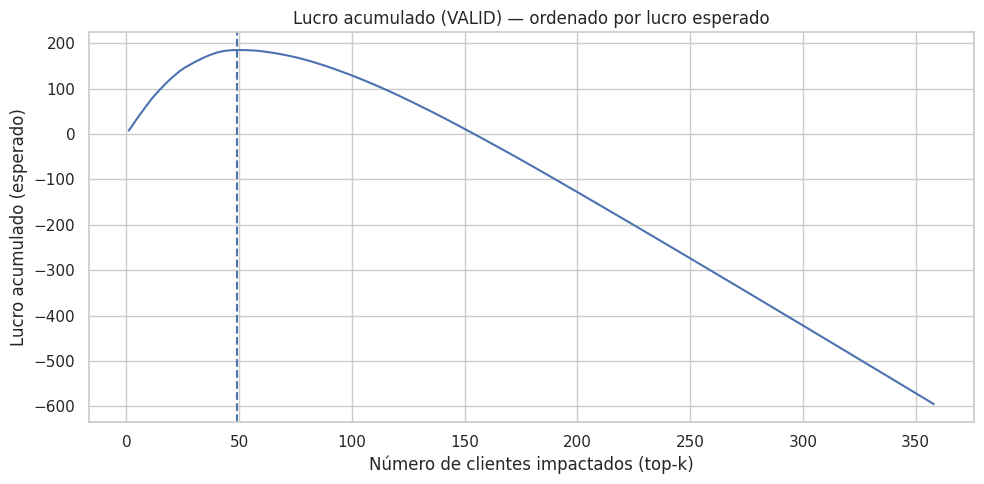

In [21]:
# Plot: curva no VALID
plt.figure(figsize=(10, 5))
plt.plot(curve_valid["rank"], curve_valid["cum_expected_profit"])
plt.axvline(best_n, linestyle="--")
plt.title("Lucro acumulado (VALID) — ordenado por lucro esperado")
plt.xlabel("Número de clientes impactados (top-k)")
plt.ylabel("Lucro acumulado (esperado)")
plt.tight_layout()

plt.savefig(PLOTS_FOLDER / "profit_curve__valid.png", dpi=150, bbox_inches="tight")
plt.show()

### 4.2. Curva no TEST (diagnóstico, mesma regra do VALID)

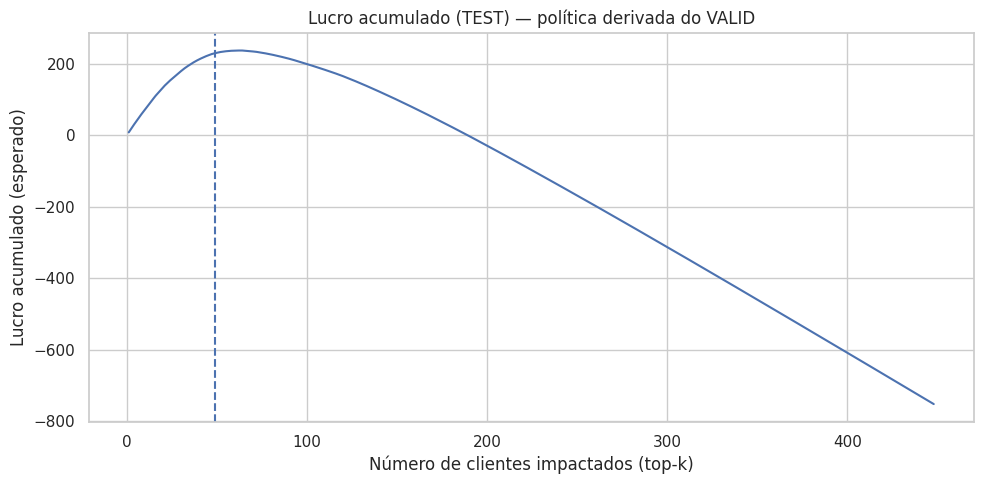

In [22]:
curve_test = profit_curve(dfp_test, profit_col="expected_profit")

plt.figure(figsize=(10, 5))
plt.plot(curve_test["rank"], curve_test["cum_expected_profit"])
plt.axvline(best_n, linestyle="--")
plt.title("Lucro acumulado (TEST) — política derivada do VALID")
plt.xlabel("Número de clientes impactados (top-k)")
plt.ylabel("Lucro acumulado (esperado)")
plt.tight_layout()

plt.savefig(PLOTS_FOLDER / "profit_curve__test.png", dpi=150, bbox_inches="tight")
plt.show()

## 5. Artefatos & Persistência

In [23]:
# Lista priorizada final (TEST)
final_ranked = dfp_test.sort_values("expected_profit", ascending=False).copy()

# (opcional) reduzir colunas para o que é acionável
cols_customer_list = [ID_COL, "p_response", "expected_profit", "y_true"]
if "segment_id" in final_ranked.columns:
    cols_customer_list.append("segment_id")

final_customer_list = final_ranked[cols_customer_list].copy()

In [24]:
# Regra executiva (derivada do VALID)
policy_rule = {
    "policy_type": "top_n_by_expected_profit",
    "top_n": int(best_n),
    "contact_rate": float(best_contact_rate),
    "gain": float(GAIN),
    "cost": float(COST),
    "derived_from": "valid",
    "notes": "Policy derived from VALID and applied one-shot on TEST",
}

In [25]:
# Persistência (JSONs e CSVs)
pd.DataFrame([policy_rule]).to_json(
    METRICS_FOLDER / "policy.json",
    orient="records",
    indent=2
)

pd.DataFrame([summary_valid]).to_json(
    METRICS_FOLDER / "summary_valid.json",
    orient="records",
    indent=2
)

pd.DataFrame([summary_test]).to_json(
    METRICS_FOLDER / "summary_test.json",
    orient="records",
    indent=2
)

final_customer_list.to_csv(TABLES_FOLDER / "customer_list.csv", index=False)
cluster_valid.to_csv(TABLES_FOLDER / "cluster_breakdown_valid.csv", index=False)
cluster_test.to_csv(TABLES_FOLDER / "cluster_breakdown_test.csv", index=False)

### Campaign Summary (evidência de execução do pipeline)

O resumo abaixo consolida o **output final da camada de decisioning** quando aplicada ao conjunto de teste (TEST), com base na política derivada no conjunto de validação (VALID).

Este artefato tem caráter **demonstrativo**, sendo utilizado para validar a correta integração entre score de propensão, política de decisão e cálculo de impacto financeiro, e não como recomendação definitiva de campanha.

#### Política aplicada

- Seleção dos **49 clientes com maior lucro esperado**, conforme threshold definido no VALID.
- Taxa de contato estimada: **13,7% da base de teste**.

#### Impacto financeiro estimado (proxy)

- Lucro esperado no VALID: **185,42**
- Lucro esperado no TEST: **229,46**

#### Distribuição por segmento (TEST)

Principais segmentos presentes na seleção:

- **Segmento High Value / Engaged**: lucro esperado ≈ 134,40 (≈ 56,5% da seleção)
- **Segmento Medium Value / Active**: lucro esperado ≈ 53,87 (≈ 6,5% da seleção)

#### Premissas e limitações

- `GAIN` e `COST` representam **hipóteses explícitas de unit economics** (GAIN = 11, COST = 3).
- A política é aplicada ao TEST em regime **one-shot**, sem recalibração.
- Os valores apresentados devem ser interpretados como **simulação controlada**, dependente do contexto de aplicação real.

In [ ]:
# Campaign Summary — artefato executivo final

campaign_md = build_campaign_summary_md(
    summary_valid=summary_valid,
    summary_test=summary_test,
    cluster_test=cluster_test,
    rule=policy_rule
)

with open(REPORTS_FOLDER / "campaignsense_summary.md", "w", encoding="utf-8") as f:
    f.write(campaign_md)

## Encerramento

Este notebook consolida a **camada de decisioning** da POC CampaignSense, estabelecendo:

- a conversão explícita do score de propensão em **decisões operacionais orientadas a lucro**;
- a definição e aplicação de uma política de contato baseada em **profit targeting**;
- a explicitação dos trade-offs entre impacto financeiro e volume acionado;
- a separação formal entre **modelagem preditiva** e **regra de decisão**;
- a simulação do fluxo completo de decisão no conjunto de teste, sem recalibração.

Com isso, a CampaignSense deixa de operar como um artefato puramente preditivo e passa a se constituir como um **motor de decisão estruturado, rastreável e orientado a valor de negócio**.